In [1]:
from IPython.display import HTML
from IPython.display import IFrame
from IPython.display import Image

# Youtube
#HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/IW3WVZV3xv8" frameborder="0" allowfullscreen></iframe>')
url = 'https://www.youtube.com/embed/IW3WVZV3xv8'
IFrame(url, width=560, height=315)

### Harris Corner[1988]


영상에서 코너를 찾는 기본적인 아이디어는 아래 그림과 같이 영상에서 작은 윈도우를 조금씩 이동시켰을 때,  
코너점의 경우는 모든 방향으로 영상변화가 커야 한다는 점이다.

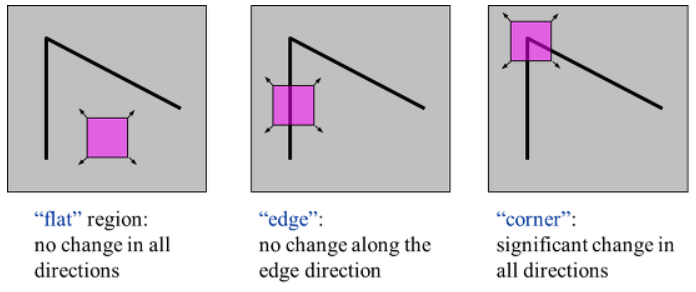

In [2]:
Image(filename='../data/ex1.png', width=560)

먼저, (△x, △y)만큼 윈도우를 이동시켰을 때 영상의 SSD(sum of squared difference) 변화량 E는 다음과 같다(W: 로컬 윈도우).

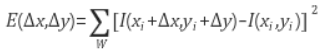

In [3]:
Image(filename='../data/ex2.png', width=300)

이 때, shift값 (△x,△y)이 매우 작다고 가정하고 gradient를 이용하여 식을 선형 근사하면 (1차 테일러 근사),

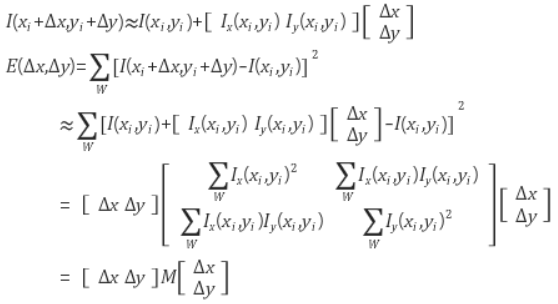

In [4]:
Image(filename='../data/ex3.png', width=560)

이 때, 2×2 행렬 M의 두 eigenvalue를 λ1, λ2 (λ1≥λ2)라 하면 영상 변화량 E는 윈도우를 λ1의 고유벡터(eigenvector) 방향으로 shift 시킬 때 최대가 되고,  
λ2의 고유벡터 방향으로 shift시킬 때 최소가 된다. 또한 두 고유값(eigenvalue) λ1, λ2는 해당 고유벡터 방향으로의 실제 영상 변화량(E) 값이 된다.  
(단, 윈도우의 shift 크기가 1일 경우)

따라서, M의 두 고유값 λ1, λ2를 구했을 때, 두 값이 모두 큰 값이면 코너점(corner point), 모두 작은값이면 'flat'한 지역,  
하나는 크고 다른 하나는 작은 값이면 'edge' 영역으로 판단할 수 있다.

실제 Harris 방법에서는 M의 고유값을 직접 구하지 않고 det(M)=λ1λ2, tr(M)=λ1+λ2 임을 이용하여  
다음 수식의 부호로 코너점 여부를 결정한다.

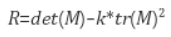

In [5]:
Image(filename='../data/ex4.png', width=200)

즉, R>0면 코너점, R<0면 edge, |R|이 매우 작은 값이면 R 부호에 관계없이 flat으로 판단한다.  
(단, k는 경험적 상수로서 0.04 ~ 0.06 사이의 값)

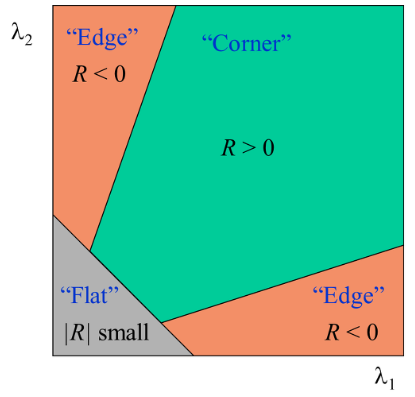

In [6]:
Image(filename='../data/ex5.png', width=300)

Harris 코너 검출 방법의 특징을 살펴보면,  
영상의 평행이동, 회전변화에는 불변이고 affine 변화, 조명 변화에도 어느 정도는 강인성을 가지고 있다.  
하지만 영상의 크기 변화에는 영향을 받기 때문에 응용에 따라서는 여러 영상 스케일에서 특징점을 뽑을 필요가 있다.

### Code

process time: 7.984375


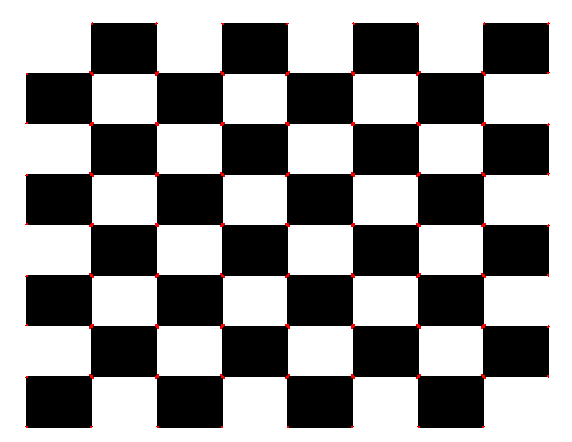

In [7]:
import cv2 as cv
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline


img_color = cv.imread('../data/chessboard.jpg', cv.IMREAD_COLOR)
img_gray = cv.cvtColor(img_color, cv.COLOR_BGR2GRAY)

# to make dI/dX and dI/dY
img_sobel_x = cv.Sobel(img_gray, cv.CV_32F, 1, 0)
img_sobel_y = cv.Sobel(img_gray, cv.CV_32F, 0, 1)

# elements of gradient (by 1st Taylor Approximation)
IxIx = img_sobel_x * img_sobel_x
IyIy = img_sobel_y * img_sobel_y
IxIy = img_sobel_x * img_sobel_y


height, width = img_color.shape[:2]

window_size = 5
offset = int(window_size/2)

r = np.zeros(img_gray.shape)

start = time.process_time()
for y in range(offset, height-offset):
    for x in range(offset, width-offset):
        window_IxIx = IxIx[y-offset:y+offset+1, x-offset:x+offset+1]
        window_IyIy = IyIy[y-offset:y+offset+1, x-offset:x+offset+1]
        window_IxIy = IxIy[y-offset:y+offset+1, x-offset:x+offset+1]
        
        # elements of matrix M
        Mxx = window_IxIx.sum()
        Myy = window_IyIy.sum()
        Mxy = window_IxIy.sum()

        # decision equation
        det = Mxx*Myy - Mxy*Mxy
        trace = Mxx + Myy

        r[y,x] = det - 0.04 * (trace ** 2)


cv.normalize(r,r,0.0,1.0,cv.NORM_MINMAX)

for y in range(offset, height-offset):
    for x in range(offset, width-offset):
        if r[y, x] > 0.4:
            img_color.itemset((y, x, 0), 0)
            img_color.itemset((y, x, 1), 0)
            img_color.itemset((y, x, 2), 255)


end = time.process_time()
print("process time:", end-start)

#cv.imshow("original", img_color)
#cv.waitKey(0)
#cv.destroyAllWindows()

plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(cv.cvtColor(img_color, cv.COLOR_BGR2RGB))
plt.show()